In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

Resistivity (ohm-m) | Conductivity (m/day) |

+---------------------+----------------------+

|         11.3        |         52.7         |

|         49.5        |         28.8         |

|         88.0        |         57.2         |

|        193.1        |        108.9         |

|        247.6        |         40.0         |

|        603.4        |        197.0         |

|        792.0        |        239.1         |

|        908.3        |        194.7         |

In [3]:
data = pd.DataFrame([[11.3, 52.7], [49.5, 28.8], [88.0, 57.2], [193.1, 108.9], [247.6, 40.0],
                    [603.4, 197.0], [792.0, 239.1], [908.3, 194.7]], columns=['res', 'cond'])

In [54]:
def unique_polynomial(x, coeffs):
    y = 0
    for i, coeff in enumerate(coeffs[::-1]):
        y += coeff * x**i
    return y

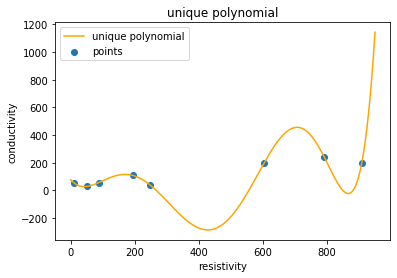

In [56]:
f = interpolate.lagrange(data.res, data.cond)
x_ = np.linspace(0, 950, 1000)
y_ = []
for x in x_:
    y_.append(unique_polynomial(x, f.coeffs))
    
plt.plot(x_, y_, color='orange')
plt.scatter(data.res, data.cond)
plt.legend(['unique polynomial', 'points'])
plt.title('unique polynomial')
plt.xlabel('resistivity')
plt.ylabel('conductivity')
plt.show()